In [1]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from transformers import BertModel, BertConfig, BertTokenizer, PreTrainedTokenizer
import csv

In [2]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower().strip()
    text = re.sub(r'\[*\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    #removes unicodes and other miscelaneous symbols left in text so model does not learn them
    text = re.sub('^\\\\u[\d\D]{4}|-|σ|→|\\\\xad', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
    return 


In [3]:
def tokenizer(text):
    #BERT tokenizer is used to tokenize text
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer.tokenize(str(text), add_special_tokens=True)
    return tokens

In [4]:
nlp = spacy.load('en_core_web_sm')

def lemmatizer(text):
    #Sometimes after cleaning the text all words in a row are removed. The if statement let's you know when this occurs
    if text == None:
        print("Excuse me but there is an unexpected None value from cleaning the text!")
        return ""
    sent = []
    tokens = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [5]:
def feed2vec(filepath, tokenize=None):
    global sentences, tokens
    #Creates a pandas dataframe for the text data from a json file
    df = pd.read_json(filepath)
    
    #Adds the column label text
    df.columns = ['text']
    
    #Text clean function is applied to the pandas dataframe
    df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))
    
    #filters out all the None values in the cleaned dataset
    #loc combines the operations in brackets into one single operation to avoid chaining indexes operations together
    #copy explicitly tells pandas to make copy when creating master_of_none
    #this is so later on only the copy is modified and there is no confusion between the copy and the original
    master_of_none = df_clean.loc[df_clean.text.notnull()].copy()
    
    if tokenize == None:
        #set the token list to None so w2v_train function knows that no tokens are present
        tokens = None
        #Lemmatizer function is applied to cleaned text with the none values removed
        master_of_none["text_lemmatized"] =  master_of_none.apply(lambda x: lemmatizer(x['text']), axis=1)
        #Lemmatized text is then further cleaned by removing pronouns
        master_of_none['text_lemmatize_clean'] = master_of_none['text_lemmatized'].str.replace('-PRON-', '')
        vocab = master_of_none['text_lemmatize_clean']
        
        #splits vocab into sentces
        sentences = [row.split() for row in vocab]
        word_freq = defaultdict(int)
        for sent in sentences:
            for i in sent:
                word_freq[i] += 1
        len(word_freq)
        
    else:
        tokens = []
        #converts the text into a string to be broken up into sentences by NLTK
        sentences = sent_tokenize(str(master_of_none["text"]))
        word_freq = defaultdict(int)
        for sent in sentences:
            #each sentence in sentences is tokenized and added to the tokens list
            tokens.append(tokenizer(sent))
            for i in sent:
                word_freq[i] += 1
        len(word_freq)
    

    return print(tokens)

In [6]:
def w2v_train(w2vmodel, last_model = False):
    #Makes sentences and tokens values visible to the other functions
    global sentences, tokens
    #When tokenizer is not used, the value of tokens is set to None
    #For generality either tokens or sentences variables are defined as words
    #This is to ensure that both tokenized and non-tokenized versions of the corpus
    #can be used to train the w2v model
    if tokens is not None:
        words = tokens
    else:
        words = sentences
    #This is for when we want to add to the vocab of an old model
    if last_model == True:
        #Previously updated model is loaded
        w2v_model = Word2Vec.load(last_model)  
        
        #model vocabulary is updated
        w2v_model.build_vocab(words, update=True)
    
    #this is for when we want to create a new w2v model from the text we are feeding. It is also the default.
    elif last_model == False:
        # min_count: minimum number of occurrences of a word in the corpus to be included in the model.
        # window: the maximum distance between the current and predicted word within a sentence.
        # size: the dimensionality of the feature vectors
        # workers: the number of cores your computer has
        w2v_model = Word2Vec(min_count=20,
                             window=5,
                             size=400,
                             workers=2)
        #the new model's vocabulary is built 
        w2v_model.build_vocab(words)
        
    # train word vectors
    #returns the number of words in the vocab and the number of words in the corpus
    try:
        w2v_model.train(words, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
    except RuntimeError:
        print("Vocab was not built. Check your w2v parameters and try again!")
    #either the new or updated version of the w2v model is saved
    w2v_model.save(w2vmodel)
    return print("Training complete!")
    

In [7]:

first_word = ['alcohol', 'ketone', 'alkene', 'carbon', 'proton', 'polymer', 'acid', 'oxidize', 'anion', 'electrophile', 'polar', 'positive', 'mechanism', 'resonance', 'synthesis', 'isomer', 'heat', 'aromatic', ]
second_word = ['hydroxyl', 'carbonyl', 'alkyne', 'nitrogen', 'hydrogen', 'chain', 'base', 'reduce', 'cation', 'nucleophile', 'nonpolar', 'negative', 'atom', 'solvent', 'electron', 'reaction', 'bond', 'equilibrium']
my_headers = ['model_name', 'alcohol + hydroxyl', 'ketone + carbonyl', 'alkene + alkyyne', 'carbon + nitrogen', 'proton + hydrogen', 'polymer + chain', 'acid + base', 'oxidize + reduce', 'anion + cation', 'electrophile + nucleophile', 'polar + nonpolar', 'positive + negative', 'mechanism + atom', 'resonance + solvent', 'synthesis + electron', 'isomer + reaction', 'heat + bond', 'aromatic + equilibrium', 'Top 10 Carbon']

def cosine_sim(w2vmodel, first_word, second_word):
    #makes w2v_data visible to the data_saver function
    global w2v_data
    model_name = w2vmodel
    
    w2v_model = Word2Vec.load(w2vmodel)
    
    w2v_data = []
    #adds the name of the saved w2vmodel to the data, so we know which model had which cos sim values
    w2v_data.append(model_name)
    
    #zips together the first_word and second_word lists so they are paired as one large list.
    for word1, word2 in zip(first_word, second_word):
        try:
        #calculates cosine similarity of synonym, antonym, or neutral pairs
            cos_sim = w2v_model.wv.similarity(word1, word2)
            #adds the cos_sim data to the w2v_data list for saving the data with the data_saver function
            w2v_data.append(cos_sim)
        #sometimes one or both words in a word pair may not be in the w2v model's vocab
        #the key error will let you know which pairs were not there and by default set the cos similarity to 0
        except KeyError:
            cos_sim = 0 
            w2v_data.append(cos_sim)
            print(f"{word1} or {word2} was not in the vocabulary")
    #Lists the top 10 words most similar to carbon and adds it to the w2v_data list
    try:
        top10 = w2v_model.wv.most_similar(positive=['carbon'])
        w2v_data.append(top10)
    except KeyError:
        top10 = 0
        print("carbon is not in the vocabulary")
    
    
    return print("Data collection and saving complete!")
    

In [8]:
def data_saver(excel_file, my_headers, new_file = None):
    try:
        #Opens a new CSV file and writes both the headers and w2v data collected from cosine_sim function
        if new_file is not None:
            with open(excel_file, 'w',  newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(my_headers)
                csvwriter.writerow(w2v_data)
        #Adds on more w2v_data to an old CSV file 
        else:
            with open(excel_file, 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(w2v_data)
    #If the CSV file is open already, then python can't open it. This explains what to do if this happens.           
    except PermissionError:
        print("Excel file is most likely open. Close it before running program")
    return print("Data saved!!!")

In [20]:
def tsne_grapher(w2vmodel):
    "Create TSNE model and plot it"
    labels = []
    tokens = []
    model = Word2Vec.load(w2vmodel)

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, perplexity=30, init='pca', early_exaggeration=12, learning_rate=500, n_iter=1000) 
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     xycoords='offset points',
                     ha='right',
                     va='bottom')
    plt.xlabel("cos sim")
    plt.ylabel("cos sim")
    plt.title("Test plot")
    plt.show()
    return

In [10]:
file1 = 'ChemLibre_JSONS/Basic_Principles_of_Organic_Chemistry_Roberts_and_Caserio.json'
file2 = 'ChemLibre_JSONS/Bruice_Map.json'
file3 = 'ChemLibre_JSONS/Catalytic_Asymmetric_Synthesis_Punniyamurthy.json'
file4 = 'ChemLibre_JSONS/Environmental_Chemistry.json'
file5 = 'ChemLibre_JSONS/How_to_be_a_Successful_Organic_Chemist_Sandtorv.json'
file6 = 'ChemLibre_JSONS/Logic_of_Organic_Synthesis_Rao.json'
file7 = 'ChemLibre_JSONS/Organic_Chemistry_A _Carbonyl_Early_Approach_McMichael.json'
file8 = 'ChemLibre_JSONS/Organic_Chemistry_Lab_Techniques_Nichols.json'
file9 = 'ChemLibre_JSONS/Organic_Chemistry_with_a_Biological_Emphasis_Soderberg.json'
file10 = 'ChemLibre_JSONS/Polymer_Chemistry.json'
file11 = 'ChemLibre_JSONS/Radical_Reactions_of_Carbohydrates_Binkley.json'
file12 = 'ChemLibre_JSONS/Schaller_Polymer.json'
file13 = 'ChemLibre_JSONS/Supplemental_Modules.json'
file14 = 'ChemLibre_JSONS/Wade_Map.json'
file15 = 'Springer_PDF/Brewing_Science_A_Multidisciplinary_Approach_by_Mosher_and_Trantham.json'
file16 = 'Springer_PDF/Advanced_Organic_Chemistry_Part_A_Structure_and_Mechanisms_by_Carey_and_Sundberg.json'
file17 = 'Springer_PDF/Advanced_Organic_Chemistry_Part_B_Reactions_and_Synthesis_by_Carey_and_Sundberg.json'
file18 = 'Springer_PDF/Principles_of_Polymer_Chemistry_by_Ravve.json'
file19 = 'Springer_PDF/Polymer_Synthesis_Theory_and_Practice_by_Braun_Cherdron_Rehahn_Ritter_and_Voit.json'
file20 = 'Springer_PDF/Polymer_Chemistry_by_Koltzsenburg_Maskos_and_Nuyken.json'

In [11]:
model1 = 'robers_and_caserio.model'
model2 = 'bruice.model'
model3 = 'punniyamurthy.model'
model4 = 'environmental.model'
model5 = 'sandtorv.model'
model6 = 'rao.model'
model7 = 'mcmichael.model'
model8 = 'nichols.model'
model9 = 'soderberg.model'
model10 = 'polymer.model'
model11 = 'binkley.model'
model12 = 'schaller.model'
model13 = 'supplemental.model'
model14 = 'wade.model'
model15 = 'mosher_and_trantham.model'
model16 = 'a_carey_and_sundberg.model'
model17 = 'b_carey_and_sundberg.model'
model18 = 'ravve.model'
model19 = 'braun_chedron_rehahn_ritter_and_voit.model'
model20 = 'koltzsenburg_maskos_and_nuyken.model'

C:\Users\louis\anaconda3\envs\Chem_NLP\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


TypeError: can only concatenate list (not "int") to list

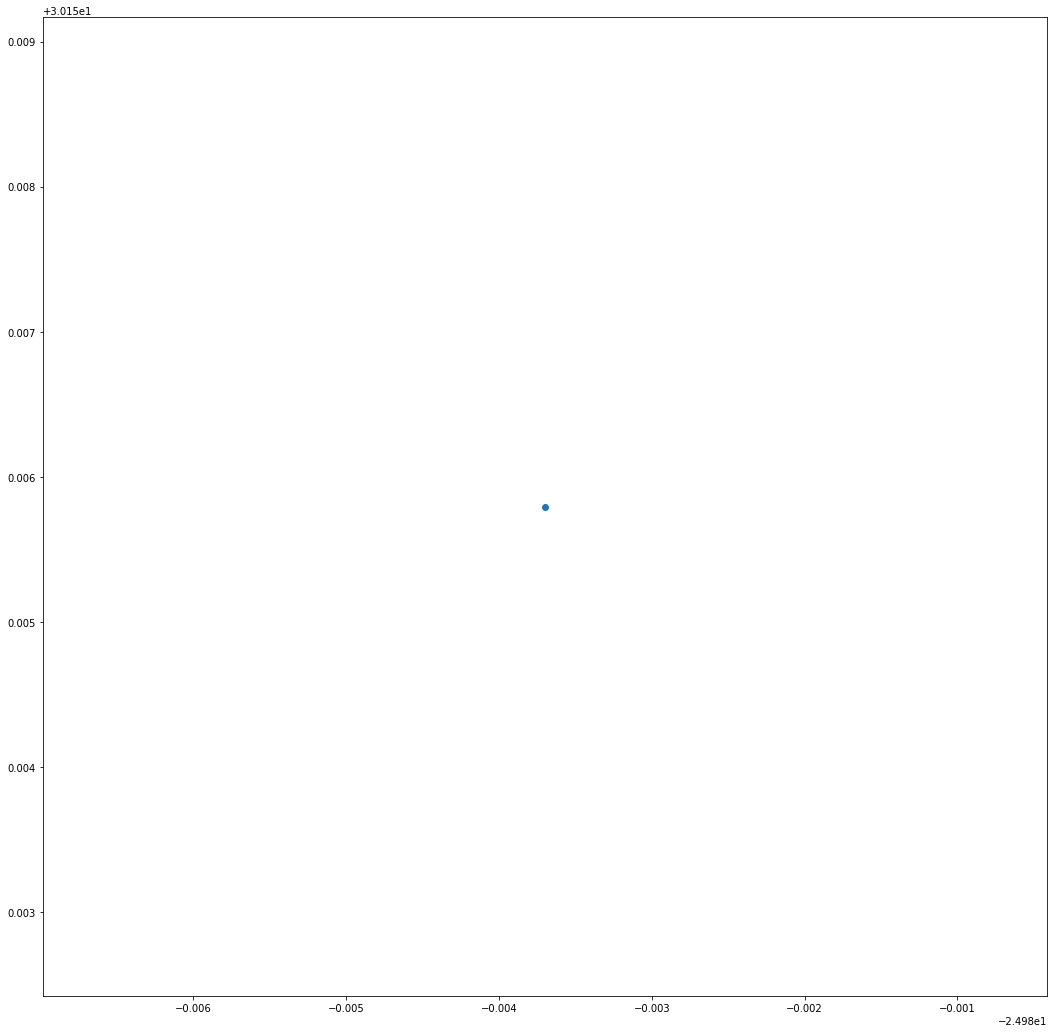

In [21]:
tsne_grapher("No_tokenize/trial_1.model")